In [ ]:
# kaggle titanic 과제
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 전처리
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Model 구현
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam

In [ ]:
# 1. Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/KDT/data/Titanic/train.csv')
print(df.shape)
display(df.head())

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# 필요없는 독립변수(Feature)가 있으면 일단 제거
df1 = df.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=False)
display(df1.head())

# 각 컬럼의 상태 확인
df1.info()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,male,22.0,1,0,S
1,1,1,female,38.0,1,0,C
2,1,3,female,26.0,0,0,S
3,1,1,female,35.0,1,0,S
4,0,3,male,35.0,0,0,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Embarked  889 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 48.9+ KB


In [ ]:
# 성별부터 처리해보아요!
# 문자를 숫자로 변경
# male -> 0, female -> 1 로 변경할 거에요!
gender_mapping = {'male' : 0,
                  'female' : 1}
df1['Sex'] = df1['Sex'].map(gender_mapping)
display(df1.head())

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,22.0,1,0,S
1,1,1,1,38.0,1,0,C
2,1,3,1,26.0,0,0,S
3,1,1,1,35.0,1,0,S
4,0,3,0,35.0,0,0,S


In [ ]:
# 의미가 유사한 SibSp, Parch 컬럼을 합쳐서 하나의 컬럼으로 만들거에요!
# 독립변수의 개수를 줄일 수 있어요! (overfitting을 피하기 위해)
df1['Family'] = df1['SibSp'] + df1['Parch']
df2 = df1.drop(['SibSp', 'Parch'], axis=1, inplace=False)
display(df2.head())

,Survived,Pclass,Sex,Age,Embarked,Family
0,0,3,0,22.0,S,1
1,1,1,1,38.0,C,1
2,1,3,1,26.0,S,0
3,1,1,1,35.0,S,1
4,0,3,0,35.0,S,0


In [ ]:
# 결측치부터 처리하고 나머지 데이터를 손을 더 봐야해요!
# Embarked 안에 결측치가 2개 있어요!
# 수정해서 사용해요! (S, C, Q)
# 승선위치 값에 대한 빈도를 이용해서 빈도가 높은 값을 찾아서
# 결측치를 대체 => S로 대체 (S라고 가정하고)
df2['Embarked'] = df2['Embarked'].fillna('S')

# 결측치가 다 채워졌으니 이제 숫자로 변경해보아요!
embarked_mapping = {"S" : 0,
                    "C" : 1,
                    "Q" : 2}
df2['Embarked'] = df2['Embarked'].map(embarked_mapping)
display(df2.head())
print(df2.isnull().sum())

,Survived,Pclass,Sex,Age,Embarked,Family
0,0,3,0,22.0,0,1
1,1,1,1,38.0,1,1
2,1,3,1,26.0,0,0
3,1,1,1,35.0,0,1
4,0,3,0,35.0,0,0


Survived      0
Pclass        0
Sex           0
Age         177
Embarked      0
Family        0
dtype: int64


In [ ]:
# 나이에 대한 결측치는 평균을 구해서
# 그 값으로 대체
df2['Age'] = df2['Age'].fillna(df2['Age'].mean())
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   Embarked  891 non-null    int64  
 5   Family    891 non-null    int64  
dtypes: float64(1), int64(5)
memory usage: 41.9 KB


In [ ]:
# Age에 대해서 Binning 처리를 해 줄거에요!
df2.loc[df2['Age'] < 8, 'Age'] = 0
df2.loc[(df2['Age'] >= 8) & (df2['Age'] < 20), 'Age'] = 1
df2.loc[(df2['Age'] >= 20) & (df2['Age'] < 60), 'Age'] = 2
df2.loc[df2['Age'] >= 60, 'Age'] = 3

display(df2.head())

,Survived,Pclass,Sex,Age,Embarked,Family
0,0,3,0,2.0,0,1
1,1,1,1,2.0,1,1
2,1,3,1,2.0,0,0
3,1,1,1,2.0,0,1
4,0,3,0,2.0,0,0


In [ ]:
# 이상치 처리 - 이상치 없음!
# 정규화
x_data = df2.drop('Survived', axis=1, inplace=False).values
t_data = df2['Survived'].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

In [ ]:
# Model 구현
model = Sequential()

# model.add(Flatten(input_shape=(5,))) <- 이거랑 같은 의미
model.add(Input(shape=(5,)))
model.add(Flatten())
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(learning_rate=1e-2),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_data_norm, t_data,
          epochs=1000, verbose=1, validation_split=0.2)
# Epoch 1000/1000
# 23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.8031 - loss: 0.4369 - val_acc: 0.8212 - val_loss: 0.3924

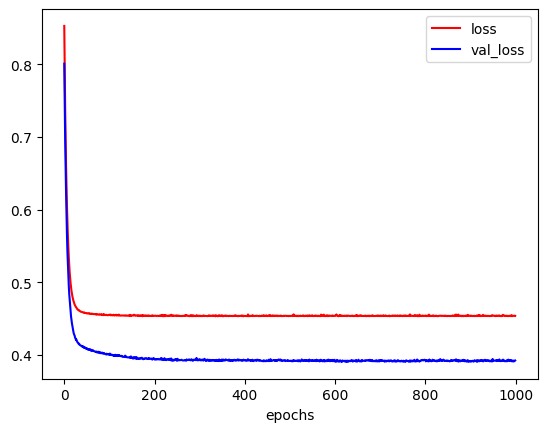

In [ ]:
# loss의 변화를 그래프로 그려보아요!
# loss는 epoch이 증가할 수록 값이 떨어져요! (이 값이 상태가 더 좋아요!)
# val_loss epoch이 증가할 수록 값이 떨어져요!
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.legend(['loss', 'val_loss'])
plt.xlabel('epochs')
plt.show()

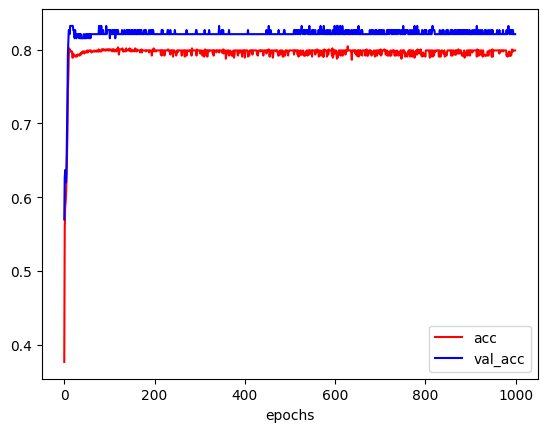

In [ ]:
plt.plot(history.history['acc'], color='r')
plt.plot(history.history['val_acc'], color='b')
plt.legend(['acc', 'val_acc'])
plt.xlabel('epochs')
plt.show()

In [ ]:
# Model을 다 만들었으니 이제 Test 데이터를 이용한 예측 결과를 뽑아내서
# 제출 파일을 만들어야해요!
test = pd.read_csv('/content/drive/MyDrive/KDT/data/Titanic/test.csv')
test.info()
display(test.head())

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
# 필요없는 독립변수(Feature)가 있으면 일단 제거
test1 = test.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin'], axis=1, inplace=False)
display(test1.head())

# 각 컬럼의 상태 확인
test1.info()

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,male,34.5,0,0,Q
1,3,female,47.0,1,0,S
2,2,male,62.0,0,0,Q
3,3,male,27.0,0,0,S
4,3,female,22.0,1,1,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Embarked  418 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 19.7+ KB


In [ ]:
# 성별부터 처리해보아요!
# 문자를 숫자로 변경
# male -> 0, female -> 1 로 변경할 거에요!
gender_mapping = {'male' : 0,
                  'female' : 1}
test1['Sex'] = test1['Sex'].map(gender_mapping)
display(test1.head())

,Pclass,Sex,Age,SibSp,Parch,Embarked
0,3,0,34.5,0,0,Q
1,3,1,47.0,1,0,S
2,2,0,62.0,0,0,Q
3,3,0,27.0,0,0,S
4,3,1,22.0,1,1,S


In [ ]:
# 의미가 유사한 SibSp, Parch 컬럼을 합쳐서 하나의 컬럼으로 만들거에요!
# 독립변수의 개수를 줄일 수 있어요! (overfitting을 피하기 위해)
test1['Family'] = test1['SibSp'] + test1['Parch']
test2 = test1.drop(['SibSp', 'Parch'], axis=1, inplace=False)
display(test2.head())

,Pclass,Sex,Age,Embarked,Family
0,3,0,34.5,Q,0
1,3,1,47.0,S,1
2,2,0,62.0,Q,0
3,3,0,27.0,S,0
4,3,1,22.0,S,2


In [ ]:
# 결측치부터 처리하고 나머지 데이터를 손을 더 봐야해요!
# Embarked 안에 결측치가 2개 있어요!
# 수정해서 사용해요! (S, C, Q)
# 승선위치 값에 대한 빈도를 이용해서 빈도가 높은 값을 찾아서
# 결측치를 대체 => S로 대체 (S라고 가정하고)
test2['Embarked'] = test2['Embarked'].fillna('S')

# 결측치가 다 채워졌으니 이제 숫자로 변경해보아요!
embarked_mapping = {"S" : 0,
                    "C" : 1,
                    "Q" : 2}
test2['Embarked'] = test2['Embarked'].map(embarked_mapping)
display(test2.head())
print(test2.isnull().sum())

,Pclass,Sex,Age,Embarked,Family
0,3,0,34.5,2,0
1,3,1,47.0,0,1
2,2,0,62.0,2,0
3,3,0,27.0,0,0
4,3,1,22.0,0,2


Pclass       0
Sex          0
Age         86
Embarked     0
Family       0
dtype: int64


In [ ]:
# 나이에 대한 결측치는 평균을 구해서
# 그 값으로 대체
test2['Age'] = test2['Age'].fillna(test2['Age'].mean())
test2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    int64  
 2   Age       418 non-null    float64
 3   Embarked  418 non-null    int64  
 4   Family    418 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 16.5 KB


In [ ]:
# Age에 대해서 Binning 처리를 해 줄거에요!
test2.loc[test2['Age'] < 8, 'Age'] = 0
test2.loc[(test2['Age'] >= 8) & (test2['Age'] < 20), 'Age'] = 1
test2.loc[(test2['Age'] >= 20) & (test2['Age'] < 60), 'Age'] = 2
test2.loc[test2['Age'] >= 60, 'Age'] = 3

display(test2.head())

,Pclass,Sex,Age,Embarked,Family
0,3,0,2.0,2,0
1,3,1,2.0,0,1
2,2,0,3.0,2,0
3,3,0,2.0,0,0
4,3,1,2.0,0,2


In [ ]:
# 이상치 처리 - 이상치 없음!
# 정규화
x_test_data_norm = scaler.transform(test2.values)

In [ ]:
predict = model.predict(x_test_data_norm)
print(predict) # 확률값이 0.5보다 작으면 사망 -> 0으로 처리
               # 확률값이 0.5 이상이면 생존 -> 1로 처리

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/KDT/data/Titanic/gender_submission.csv')
display(submission.head())

submission['Survived'] = predict
display(submission.head())

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


,PassengerId,Survived
0,892,0.144110
1,893,0.545892
2,894,0.177773
3,895,0.091279
4,896,0.483665


In [ ]:
submission['Survived'] = np.where(submission['Survived'] >= 0.5, 1, 0)
display(submission.head())

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [ ]:
submission.to_csv('Titanic_Prediction.csv', index=False)

In [ ]:
%reset

In [ ]:
# BMI 데이터를 이용한 다중분류 구현
# Multinomial Classification
# module import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 전처리
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Model 구현
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Model 평가
from sklearn.metrics import accuracy_score

In [ ]:
# 1. Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/KDT/data/bmi.csv', skiprows=3)
display(df.head())

,label,height,weight
0,1,188,71
1,2,161,68
2,0,178,52
3,2,136,63
4,1,145,52


In [ ]:
# 데이터 전처리
# 1. 결측치 확인 및 처리 -> 결측치가 없어요!
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   label   20000 non-null  int64
 1   height  20000 non-null  int64
 2   weight  20000 non-null  int64
dtypes: int64(3)
memory usage: 468.9 KB


,0
label,0
height,0
weight,0


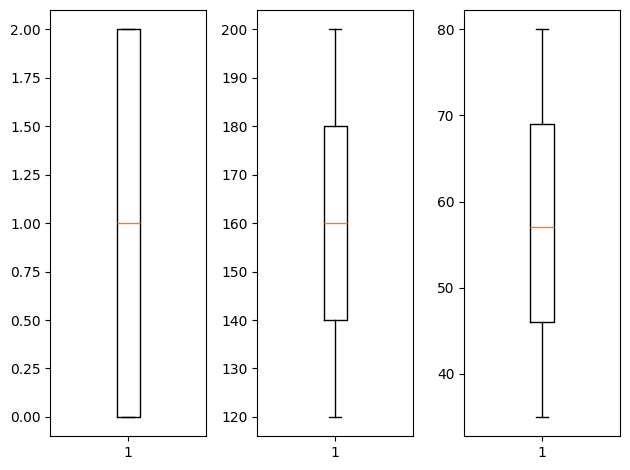

In [ ]:
# 2. 이상치 확인 및 처리 -> 이상치도 없어요!
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.boxplot(df['label'].values)
ax2.boxplot(df['height'].values)
ax3.boxplot(df['weight'].values)

plt.tight_layout()

plt.show()

In [ ]:
# 3. Feature(독립변수)에 대해서만 정규화 진행
x_data = df[['height', 'weight']].values # 2차원
t_data = df['label'].values # 1차원 => 여기에 있는 값은 분류값
                            # 따라서 원래 이 값을 one-hot encdoing 처리해야해요!
                            # 하지만 tensorflow나 sklearn이 알아서 처리할 수 있어요!

scaler = MinMaxScaler()
scaler.fit(x_data)
x_data_norm = scaler.transform(x_data)

In [ ]:
# 4. 모델 평가를 위해서 train과 test data를 분리
x_data_train_norm, x_data_test_norm, t_data_train, t_data_test = \
train_test_split(x_data_norm, t_data,
                 test_size=0.3, stratify=t_data)

In [ ]:
# 5. Model 구현(sklearn) - 다중 분류 모델 구현
sklearn_model = linear_model.LogisticRegression()

# 학습할 때 One-Hot Encoding으로 종속변수(t_data)를 변환시키지 않고
# 입력했는데 이 값을 sklearn이 알아서 내부적으로 변환시켜서 사용해요.
sklearn_model.fit(x_data_train_norm, t_data_train)

# 예측값 추출
sklearn_predict = sklearn_model.predict(x_data_test_norm)

# 예측값과 test 데이터에 대한 정답을 비교해서 모델의 정확도를 출력!
print(accuracy_score(sklearn_predict, t_data_test))

# 모델이 어느정도 완성되었으니 예측을 해보아요!
my_status = np.array([[165, 62]])
print(sklearn_model.predict(scaler.transform(my_status)))
print(sklearn_model.predict_proba(scaler.transform(my_status)))

0.9826666666666667
[1]
[[0.00777841 0.92189886 0.07032273]]


In [ ]:
# 6. Tensorflow 구현
keras_model = Sequential()

keras_model.add(Flatten(name='Input', input_shape=(2,)))
keras_model.add(Dense(name='Output', units=3, activation='softmax'))

keras_model.summary()

keras_model.compile(optimizer=Adam(learning_rate=1e-2),
                    loss='sparse_categorical_crossentropy', # sparse를 붙이면 모델이 알아서 one-hot encoding을 수행함!
                    metrics=['accuracy'])

history = keras_model.fit(x_data_train_norm, t_data_train.reshape(-1, 1),
                epochs=200, verbose=1,
                validation_split=0.3, batch_size=100)
# Epoch 200/200
# 98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9841 - loss: 0.0800 - val_accuracy: 0.9840 - val_loss: 0.0796

In [ ]:
# 모델 평가(Evaluation)
keras_result = keras_model.evaluate(x_data_test_norm, t_data_test.reshape(-1, 1))
print(keras_result)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9806 - loss: 0.0820
[0.0800541490316391, 0.9838333129882812]


In [ ]:
my_status = np.array([[165, 62]])
print(keras_model.predict(scaler.transform(my_status)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[3.0968402e-04 9.8861164e-01 1.1078653e-02]]
